In [1]:
#모듈 로딩
# Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import torch.optim.lr_scheduler as lr_scheduler 


# Data 및 시각화 관련
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [3]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()
        
        # 은닉층들을 nn.ModuleList로 관리
        layers = []
        in_features = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())  # 활성화 함수로 ReLU 추가
            in_features = hidden_size  # 다음 레이어의 입력 크기는 현재 레이어의 출력 크기
        
        # Dropout과 마지막 출력층 추가
        layers.append(nn.Dropout(0.3))  # Dropout 추가
        layers.append(nn.Linear(in_features, output_size))
        
        self.network = nn.Sequential(*layers)  # Sequential로 레이어 묶음
    
    def forward(self, x):
        return self.network(x)

In [2]:
mbti_df=pd.read_csv('../data/MBTI.csv')
mbti_df

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ
...,...,...
106062,stay frustrate world life want take long nap w...,INFP
106063,fizzle around time mention sure mistake thing ...,INFP
106064,schedule modify hey w intp strong wing underst...,INFP
106065,enfj since january busy schedule able spend li...,INFP


In [3]:
mbti_df['E/I_type']=mbti_df['type'].apply(lambda x: 1 if 'I' in x else 0)  # 'I'면 1, 'E'면 0
mbti_df

,posts,type,E/I_type
0,know intj tool use interaction people excuse a...,INTJ,1
1,rap music ehh opp yeah know valid well know fa...,INTJ,1
2,preferably p hd low except wew lad video p min...,INTJ,1
3,drink like wish could drink red wine give head...,INTJ,1
4,space program ah bad deal meing freelance max ...,INTJ,1
...,...,...,...
106062,stay frustrate world life want take long nap w...,INFP,1
106063,fizzle around time mention sure mistake thing ...,INFP,1
106064,schedule modify hey w intp strong wing underst...,INFP,1
106065,enfj since january busy schedule able spend li...,INFP,1


In [4]:
feature_df=mbti_df['posts'].str.replace(' ',',')
feature_df=feature_df.values
feature_df.shape

(106067,)

In [5]:
target_df=mbti_df['E/I_type'].values
target_df.shape

(106067,)

In [14]:
#벡터화
tfidf = TfidfVectorizer(max_features=5000)  # 최대 5000개의 단어만 사용
X = tfidf.fit_transform(feature_df)

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, target_df, test_size=0.2, random_state=42)

# PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train.toarray())
X_test_tensor = torch.FloatTensor(X_test.toarray())
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [15]:
train_dataset = MyDataset(X_train_tensor, y_train_tensor)
test_dataset = MyDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [16]:
input_size = 5000
hidden_sizes = [1000, 500, 300, 100, 50]  
output_size = 1  # 이진 분류

model = MLPModel(input_size, hidden_sizes, output_size)

criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',patience=10,verbose=True)

c:\Users\desktop\anaconda3\envs\TORCH_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
print(model)

MLPModel(
  (network): Sequential(
    (0): Linear(in_features=5000, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.3, inplace=False)
    (11): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [19]:
# 7. 모델 학습
epochs = 100
patience = 10  # 성능 향상이 없을 때 10번의 에포크 후 학습을 중단

best_loss = float('inf')  # 초기값을 매우 큰 값으로 설정
trigger_times = 0  # 개선되지 않은 에포크 수

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_score=0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features).view(-1)
        loss = criterion(outputs, targets.float())  # float형으로 변환

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_loss_train = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss_train}')

    #최적화 스케줄러 인스턴스 업데이트
    scheduler.step(loss)
    print(f'scheduler.num_bad_epochs: {scheduler.num_bad_epochs}',end=' ')
    print(f'scheduler.patience: {scheduler.patience}')

#모델 평가
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features).view(-1)
        predicted = torch.round(torch.sigmoid(outputs))  # 시그모이드 함수로 확률 변환
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Epoch [1/100], Loss: 0.3128540723431479
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [2/100], Loss: 0.22528998931057942
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [3/100], Loss: 0.1909135689222862
scheduler.num_bad_epochs: 1 scheduler.patience: 10
Epoch [4/100], Loss: 0.11709958847544014
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [5/100], Loss: 0.05156686990406838
scheduler.num_bad_epochs: 1 scheduler.patience: 10
Epoch [6/100], Loss: 0.018468734439156722
scheduler.num_bad_epochs: 2 scheduler.patience: 10
Epoch [7/100], Loss: 0.0069873128035154
scheduler.num_bad_epochs: 3 scheduler.patience: 10
Epoch [8/100], Loss: 0.005330595432279406
scheduler.num_bad_epochs: 4 scheduler.patience: 10
Epoch [9/100], Loss: 0.004910171227460857
scheduler.num_bad_epochs: 5 scheduler.patience: 10
Epoch [10/100], Loss: 0.004034481215650174
scheduler.num_bad_epochs: 6 scheduler.patience: 10
Epoch [11/100], Loss: 0.0034456651164779953
scheduler.num_bad_epochs: 7 schedu

KeyboardInterrupt: 

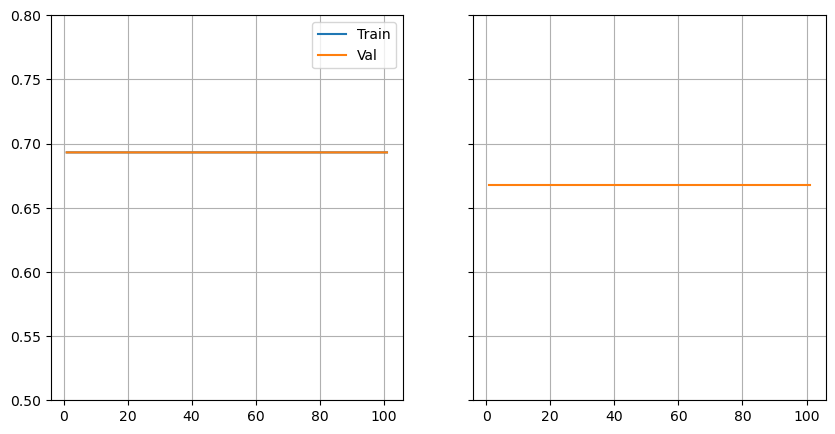

In [28]:
#학습 결과 확인(학습과 검증의 Loss, 성능지표 변화 확인) w. 시각화

th=len(score_history[1])
fg,axes=plt.subplots(1,2,figsize=(10,5),sharey=True)
axes[0].plot(range(1,th+1),loss_history[0][:th],label='Train')
axes[0].plot(range(1,th+1),loss_history[1][:th],label='Val')
axes[0].set_ylim([0.5,0.8])
axes[0].grid()
axes[0].legend()

axes[1].plot(range(1,th+1),score_history[0][:th],label='Train')
axes[1].plot(range(1,th+1),score_history[1][:th],label='Val')
axes[1].grid()

axes[1].legend

plt.show()